# PyTorch Transfer Learning

What is transfer learning?

Transfer learning involves taking the parameters of what one model has learned on another dataset and applying it to our own problem.

* Pretrained model = Foundation Model



In [1]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.4.0
0.19.0


Now we've got the versions of torch and torchvision, we're after, let's import the code we've written in previous sections so that we don't have to write it all again.

In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install if it doesn't work
try:
    from torchinfo import summary
    print("torchinfo imported.")
except:
    print("[INFO] Couldn't find torchinfo... installing it")
    !pip install torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular import data_setup, engine
    print("going_modular modules imported successfully.")
except:
    # Get the going modular scripts
    print("Gouing modular not found.")

torchinfo imported.
going_modular modules imported successfully.


c:\Users\ac253\anaconda3\envs\ARC\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get data

We need our pizza, steak, sushi data to build a transfer learning model on.

In [4]:
from going_modular import get_data

train_dir , test_dir = get_data.download_data(
    raw_url_to_dataset="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"
    )

[INFO] d:\Google Drive\Udemy\PyTorch for Deep Learning Bootcamp\data\pizza_steak_sushi directory already exists, skipping download.
Unzipping pizza, steak, sushi data...


## 2. Create Datasets and DataLoaders

Now we have got some data, we want to turn it into PyTorch Dataloaders.

To do so, we can use `data_setup.py` and the `create_dataloaders()` function we made in the 0.5 PyTorch Going Modular section.

There's one thing we have ti think about when loading: how to **transform** it?

And with `torchvision` 0.13+ there's two ways to do this:

1. Manually created transforms - you defice what transforms you want your data to go through.
2. Automatically created transforms - the transforms for your data are defined by the model you'd like to use.

Important point: When using a pretrained model, it's important that the data(including your custom data) that you pass through it is **transformed** in the same way that the data the model was trained on.

### 2.1 Creating a transform for `torchvision.models` (manual creation)

`torchvision.models` contains pretrained models(models ready for transfer learning) right within `torchvision`.

In [5]:
from torchvision import transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

manual_transforms = transforms.Compose([
    transforms.Resize(size = (224, 224)), # resize the images to 224,224 (height, width)
    transforms.ToTensor(), # get images into range [0,1]
    normalize # make sure images have the same distribution as ImageNet (where our pretrained models have been trained)
])

In [6]:
from going_modular import data_setup

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               train_transform=manual_transforms,
                                                                               test_transform=manual_transforms,
                                                                               batch_size= 32,
                                                                               num_workers=0)

train_dataloader, test_dataloader, class_names                                        

(<torch.utils.data.dataloader.DataLoader at 0x1e65a718910>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a transform for `torchvision.models` (auto creation)

As of `torchvision` v0.13+ there is now support for automatic data transform creation based on the pretrained model weights you're using.

In [7]:
import torchvision
torchvision.__version__

'0.19.0'

In [8]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # "DEFAULT" = best available weights
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [9]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [10]:
# Create Dataloaders using automatic transforms
from going_modular import data_setup

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               train_transform=auto_transforms,
                                                                               test_transform=auto_transforms,
                                                                               batch_size= 32)

train_dataloader, test_dataloader, class_names           

(<torch.utils.data.dataloader.DataLoader at 0x1e65a7198d0>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model

There are various places to get a pretrained model, such as:
1. PyTorch domain libraries
2. Libraries like `timm` (torch image models)
3. HuggingFace Hub (for plenty of different models)
4. Paperswithcode (for models across different problem spaces/domains)

### 3.1 Which pretrained model should you use?

*Experiment, experiment, Experiment!*

Three things to consider:
1. Speed — how fast does it run?
2. Size — how big is the model?
3. Performance — how well does it go on your chosen problem (e.g. how well does it classify food images? for FoodVision Mini) ?

Where does the model live?

Is it on device? (like a self-driving car)

Or does it live on a server?

Which model should we choose?

For our case (deploying FoodVision Mini on a mobile device), it looks like EffNetB0 is one of our best options in terms of performance vs size.

However, in the light of The Bitter Lesson, if we had infinite compute, we'd likely pick the biggest model + most parameters + most general we could.


### 3.2 Setting up a pretrained model

We want to create a instance of pretrained `EfficientNetB0` 

In [11]:
# OLD method of creating a pretrained model (prior to torchvision v0.13)
# model = torchvision.models.efficientnet_b0(pretrained = True)

# NEW method of creating a pretrained model (after torchvision v0.13)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # DEFAULT = best available weights
model = torchvision.models.efficientnet_b0(weights = weights).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [12]:
model.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [13]:
model.avgpool

AdaptiveAvgPool2d(output_size=1)

In [14]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

### 3.3 Getting a summary of our model using `torchinfo.summary()`

In [15]:
# Print with torchinfo
from torchinfo import summary

summary(model=model,
        input_size=(1,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width= 20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

### 3.4 Freeezing the base model and changing the output layer to suit our needs

With a feature extractor model, typically you will "freeze" the base layers on a pretrained/foundation model and update the output layers to suit your own problem.

In [16]:
# Freeze all the base layers in EffNetB0
for param in model.features.parameters():
    param.requires_grad = False

In [17]:
# Update the classifier head of our model to suit our problem
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280,
              out_features=len(class_names))
).to(device)


model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [18]:
# Print with torchinfo
from torchinfo import summary

summary(model=model,
        input_size=(1,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width= 20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## 4. Train model

In [19]:
# Define loss fn and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [20]:
# import train function
from going_modular import engine

# Set the manual seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=50,
                       device=device)

# End the timer and print out how long it took
end_time =timer()
print(f"[INFO] Total training time: {end_time - start_time}")

  2%|▏         | 1/50 [00:06<05:27,  6.69s/it]

Epoch: 1 | train_loss: 1.0950 | train_acc: 0.4023 | test_loss: 0.9129 | test_acc: 0.5502


  4%|▍         | 2/50 [00:12<04:51,  6.08s/it]

Epoch: 2 | train_loss: 0.8693 | train_acc: 0.7773 | test_loss: 0.7901 | test_acc: 0.8456


  6%|▌         | 3/50 [00:17<04:32,  5.80s/it]

Epoch: 3 | train_loss: 0.7714 | train_acc: 0.7891 | test_loss: 0.7423 | test_acc: 0.8561


  8%|▊         | 4/50 [00:24<04:40,  6.10s/it]

Epoch: 4 | train_loss: 0.7138 | train_acc: 0.7656 | test_loss: 0.6367 | test_acc: 0.8655


 10%|█         | 5/50 [00:30<04:31,  6.03s/it]

Epoch: 5 | train_loss: 0.6221 | train_acc: 0.7930 | test_loss: 0.6255 | test_acc: 0.8561


 12%|█▏        | 6/50 [00:35<04:18,  5.87s/it]

Epoch: 6 | train_loss: 0.5755 | train_acc: 0.9062 | test_loss: 0.5729 | test_acc: 0.8759


 14%|█▍        | 7/50 [00:41<04:14,  5.91s/it]

Epoch: 7 | train_loss: 0.5265 | train_acc: 0.9141 | test_loss: 0.5455 | test_acc: 0.8759


 16%|█▌        | 8/50 [00:48<04:16,  6.12s/it]

Epoch: 8 | train_loss: 0.5262 | train_acc: 0.8125 | test_loss: 0.5270 | test_acc: 0.8769


 18%|█▊        | 9/50 [00:55<04:20,  6.35s/it]

Epoch: 9 | train_loss: 0.5685 | train_acc: 0.8086 | test_loss: 0.5061 | test_acc: 0.8456


 20%|██        | 10/50 [01:01<04:10,  6.26s/it]

Epoch: 10 | train_loss: 0.4873 | train_acc: 0.8164 | test_loss: 0.4386 | test_acc: 0.9062


 22%|██▏       | 11/50 [01:07<03:59,  6.15s/it]

Epoch: 11 | train_loss: 0.4367 | train_acc: 0.9297 | test_loss: 0.4622 | test_acc: 0.8456


 24%|██▍       | 12/50 [01:13<03:52,  6.12s/it]

Epoch: 12 | train_loss: 0.4584 | train_acc: 0.8203 | test_loss: 0.4936 | test_acc: 0.8352


 26%|██▌       | 13/50 [01:18<03:41,  5.98s/it]

Epoch: 13 | train_loss: 0.4261 | train_acc: 0.9297 | test_loss: 0.4146 | test_acc: 0.8456


 28%|██▊       | 14/50 [01:24<03:31,  5.87s/it]

Epoch: 14 | train_loss: 0.3556 | train_acc: 0.9492 | test_loss: 0.4289 | test_acc: 0.8665


 30%|███       | 15/50 [01:30<03:23,  5.82s/it]

Epoch: 15 | train_loss: 0.3474 | train_acc: 0.9727 | test_loss: 0.4269 | test_acc: 0.8352


 32%|███▏      | 16/50 [01:35<03:11,  5.64s/it]

Epoch: 16 | train_loss: 0.3673 | train_acc: 0.9492 | test_loss: 0.4304 | test_acc: 0.8352


 34%|███▍      | 17/50 [01:40<03:00,  5.46s/it]

Epoch: 17 | train_loss: 0.3223 | train_acc: 0.9531 | test_loss: 0.4406 | test_acc: 0.8352


 36%|███▌      | 18/50 [01:45<02:52,  5.40s/it]

Epoch: 18 | train_loss: 0.3251 | train_acc: 0.9648 | test_loss: 0.4215 | test_acc: 0.8248


 38%|███▊      | 19/50 [01:51<02:50,  5.49s/it]

Epoch: 19 | train_loss: 0.2939 | train_acc: 0.9688 | test_loss: 0.4349 | test_acc: 0.8352


 40%|████      | 20/50 [01:56<02:42,  5.42s/it]

Epoch: 20 | train_loss: 0.4165 | train_acc: 0.8516 | test_loss: 0.4337 | test_acc: 0.8352


 42%|████▏     | 21/50 [02:02<02:36,  5.39s/it]

Epoch: 21 | train_loss: 0.3345 | train_acc: 0.9570 | test_loss: 0.3541 | test_acc: 0.8561


 44%|████▍     | 22/50 [02:07<02:28,  5.32s/it]

Epoch: 22 | train_loss: 0.3486 | train_acc: 0.8359 | test_loss: 0.3649 | test_acc: 0.8456


 46%|████▌     | 23/50 [02:12<02:20,  5.20s/it]

Epoch: 23 | train_loss: 0.4095 | train_acc: 0.8438 | test_loss: 0.3345 | test_acc: 0.8561


 48%|████▊     | 24/50 [02:18<02:21,  5.46s/it]

Epoch: 24 | train_loss: 0.3136 | train_acc: 0.8477 | test_loss: 0.3814 | test_acc: 0.8561


 50%|█████     | 25/50 [02:23<02:18,  5.54s/it]

Epoch: 25 | train_loss: 0.3314 | train_acc: 0.8320 | test_loss: 0.3613 | test_acc: 0.8561


 52%|█████▏    | 26/50 [02:29<02:15,  5.63s/it]

Epoch: 26 | train_loss: 0.3336 | train_acc: 0.8398 | test_loss: 0.3614 | test_acc: 0.8665


 54%|█████▍    | 27/50 [02:35<02:06,  5.52s/it]

Epoch: 27 | train_loss: 0.3324 | train_acc: 0.8633 | test_loss: 0.4220 | test_acc: 0.8144


 56%|█████▌    | 28/50 [02:40<02:04,  5.65s/it]

Epoch: 28 | train_loss: 0.3153 | train_acc: 0.8477 | test_loss: 0.3857 | test_acc: 0.8665


 58%|█████▊    | 29/50 [02:46<01:56,  5.57s/it]

Epoch: 29 | train_loss: 0.2772 | train_acc: 0.9570 | test_loss: 0.3470 | test_acc: 0.8665


 60%|██████    | 30/50 [02:52<01:52,  5.61s/it]

Epoch: 30 | train_loss: 0.2969 | train_acc: 0.9336 | test_loss: 0.3365 | test_acc: 0.8561


 62%|██████▏   | 31/50 [02:57<01:44,  5.50s/it]

Epoch: 31 | train_loss: 0.3642 | train_acc: 0.8359 | test_loss: 0.3243 | test_acc: 0.8561


 64%|██████▍   | 32/50 [03:02<01:35,  5.33s/it]

Epoch: 32 | train_loss: 0.3419 | train_acc: 0.8281 | test_loss: 0.3418 | test_acc: 0.8665


 66%|██████▌   | 33/50 [03:07<01:32,  5.44s/it]

Epoch: 33 | train_loss: 0.2425 | train_acc: 0.9844 | test_loss: 0.3701 | test_acc: 0.8248


 68%|██████▊   | 34/50 [03:14<01:31,  5.73s/it]

Epoch: 34 | train_loss: 0.2258 | train_acc: 0.9648 | test_loss: 0.4104 | test_acc: 0.8456


 70%|███████   | 35/50 [03:19<01:25,  5.68s/it]

Epoch: 35 | train_loss: 0.4119 | train_acc: 0.8438 | test_loss: 0.4070 | test_acc: 0.8049


 72%|███████▏  | 36/50 [03:24<01:16,  5.48s/it]

Epoch: 36 | train_loss: 0.2932 | train_acc: 0.8516 | test_loss: 0.3438 | test_acc: 0.8561


 74%|███████▍  | 37/50 [03:30<01:10,  5.41s/it]

Epoch: 37 | train_loss: 0.2253 | train_acc: 0.9688 | test_loss: 0.3212 | test_acc: 0.8864


 76%|███████▌  | 38/50 [03:36<01:07,  5.66s/it]

Epoch: 38 | train_loss: 0.3472 | train_acc: 0.8164 | test_loss: 0.3423 | test_acc: 0.8456


 78%|███████▊  | 39/50 [03:42<01:03,  5.80s/it]

Epoch: 39 | train_loss: 0.3605 | train_acc: 0.8398 | test_loss: 0.3394 | test_acc: 0.8561


 80%|████████  | 40/50 [03:47<00:56,  5.69s/it]

Epoch: 40 | train_loss: 0.2702 | train_acc: 0.8516 | test_loss: 0.3756 | test_acc: 0.8561


 82%|████████▏ | 41/50 [03:54<00:52,  5.83s/it]

Epoch: 41 | train_loss: 0.3464 | train_acc: 0.8516 | test_loss: 0.4615 | test_acc: 0.8049


 84%|████████▍ | 42/50 [04:12<01:16,  9.56s/it]

Epoch: 42 | train_loss: 0.3411 | train_acc: 0.8594 | test_loss: 0.3517 | test_acc: 0.8561


 86%|████████▌ | 43/50 [04:24<01:12, 10.34s/it]

Epoch: 43 | train_loss: 0.2445 | train_acc: 0.9609 | test_loss: 0.3312 | test_acc: 0.8769


 88%|████████▊ | 44/50 [04:30<00:53,  8.93s/it]

Epoch: 44 | train_loss: 0.3529 | train_acc: 0.8242 | test_loss: 0.3318 | test_acc: 0.8665


 90%|█████████ | 45/50 [04:37<00:42,  8.46s/it]

Epoch: 45 | train_loss: 0.3329 | train_acc: 0.8477 | test_loss: 0.3285 | test_acc: 0.8873


 92%|█████████▏| 46/50 [04:44<00:32,  8.07s/it]

Epoch: 46 | train_loss: 0.2889 | train_acc: 0.8516 | test_loss: 0.3563 | test_acc: 0.8665


 94%|█████████▍| 47/50 [04:51<00:23,  7.72s/it]

Epoch: 47 | train_loss: 0.2969 | train_acc: 0.8477 | test_loss: 0.3313 | test_acc: 0.8873


 96%|█████████▌| 48/50 [04:58<00:15,  7.57s/it]

Epoch: 48 | train_loss: 0.2071 | train_acc: 0.9844 | test_loss: 0.3512 | test_acc: 0.8665


 98%|█████████▊| 49/50 [05:05<00:07,  7.37s/it]

Epoch: 49 | train_loss: 0.2034 | train_acc: 0.9922 | test_loss: 0.3185 | test_acc: 0.8665


100%|██████████| 50/50 [05:13<00:00,  6.26s/it]

Epoch: 50 | train_loss: 0.2488 | train_acc: 0.9727 | test_loss: 0.3531 | test_acc: 0.8561
[INFO] Total training time: 313.1265999999998


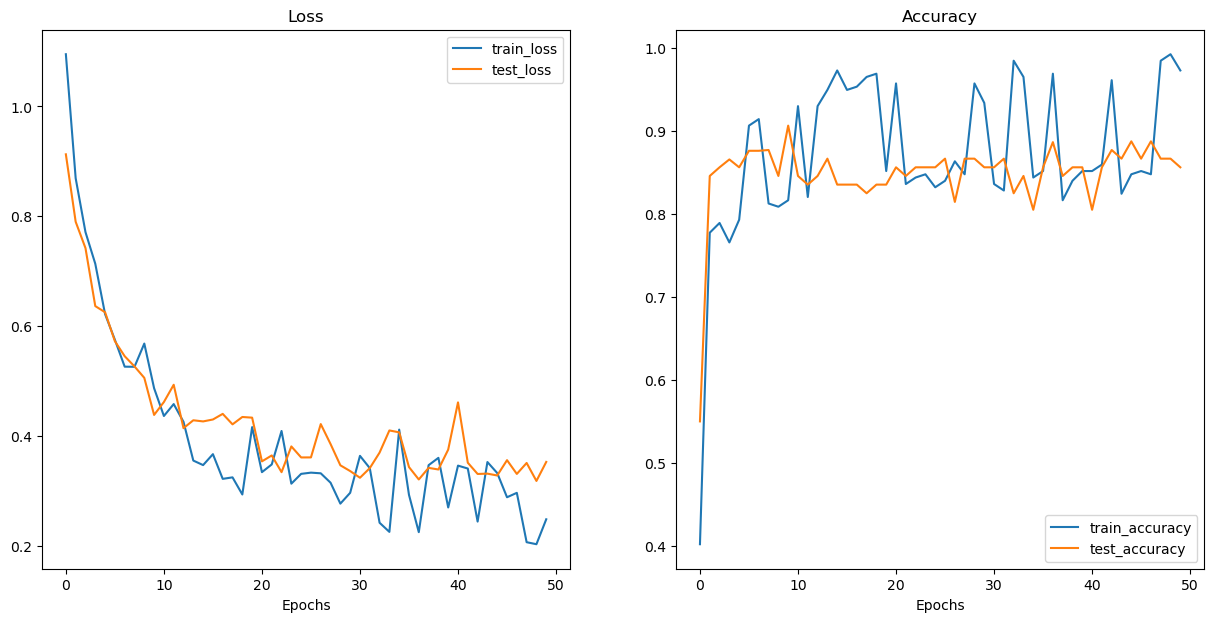

In [21]:
## 5. Evaluate model by plotting loss curves
try:
    from helper_functions import plot_loss_curves
    
except:
    print(f"[INFO] Counldn't find helper_functions.py, downloading")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results=results)

What do our loss curves look like in terms of our ideal loss curve?


## 6. Make predictions on images from the test set

Let's adhere to the data explorer's motto of *visualize, visualize, visualize*!

And make some qualitative predicitons on our test set.

Some things to keep in mind when making predictions/inference on test data/custom data.

We have to make sure that our test/custom data is:
* Same shape - images need to be same shape as model was trained on
* Same datatype - custom data should be in the same data type
* Same device - custom data/test data should be on the same device as the model
* Same transform - if you've transformed your custom data, ideally you will transform the test data and custom data the same

To do all of this automagically, let's create a function called `pred_and_plot_image()`.

1. Take in a trained model, a list of class names, a filepath to a target image, an image size, a transform and a target device.
2. Open the image with `PIL.Image.open()`
3. Create a transform if one doesn't exist.
4. Make sure the model is on the target device
5. Turn the model to `model.eval()` mode to make sure it's ready for inference
(this will turn off things like `nn.Dropout()`)
6. Transform the target image and make sure its dimensionnality is suited for the model (this mainly relates to batch size)
7. Make a prediction on the image by passing to the model
8. Convert the model's output logits to prediction probabilities using `torch.softmax()`
9. Convert model's prediction probabilities to prediciton labels using `torch.argmax()`
10. Plot the image with `matplotlib` and set the title to the prediction label from step 9  and prediction probability from step 8.

In [22]:
from typing import List, Tuple
from torchvision import transforms
from PIL import Image

def pred_and_plot_image(model: torch.nn.Module,
                        class_names: List[str],
                        image_path : str,
                        image_size: Tuple[int,int] = (224,224),
                        transform : torchvision.transforms = None,
                        device: torch.device = device):
    
    """Makes a prediciton on a target image with a trained model and plots the image and prediction."""
    # 2. Open the image
    custom_image = Image.open(image_path)

    # 3. Create a transform
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    # 4. Moving the model on the device
    model.to(device)

    # 5. Setting the model to eval mode
    model.eval()
    with torch.inference_mode():
        # 6. Transform the target image
        custom_image_transformed = image_transform(custom_image).unsqueeze(dim =0) # [batch_size, color_channels, height, width]

        # 7. Making a prediciton on the image and also ensure that it is on the target device

        pred_logits = model(custom_image_transformed.to(device))

    # 8. converting logits to pred probs
    pred_probs = torch.softmax(pred_logits, dim = 1)

    # 9. Converting pred probs to pred labels
    pred_label = torch.argmax(pred_probs, dim = 1).cpu()

    # 10. plotting the image and with prediciton class and prediction probability
    plt.figure(figsize=(10,7))
    plt.imshow(custom_image)

    # 10.1 Obtain the class of the image
    if class_names:
        title = f"Pred: {class_names[pred_label.cpu()]} | Prob: {pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {pred_label.cpu()} | Prob: {pred_probs.max().cpu():.3f}"

    plt.title(title,fontsize = 20)
    plt.axis(False)

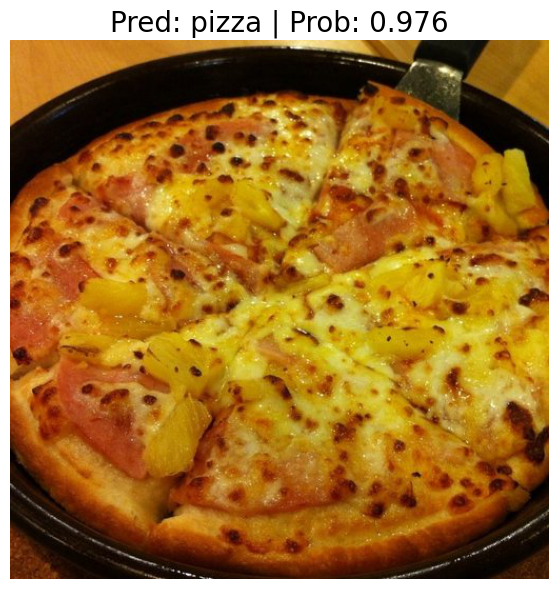

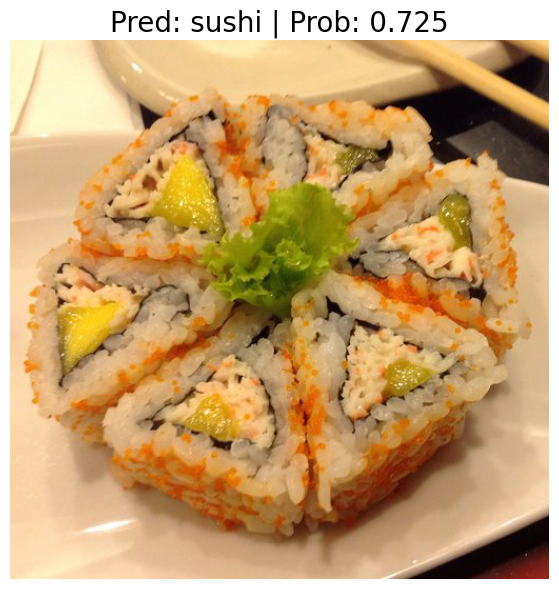

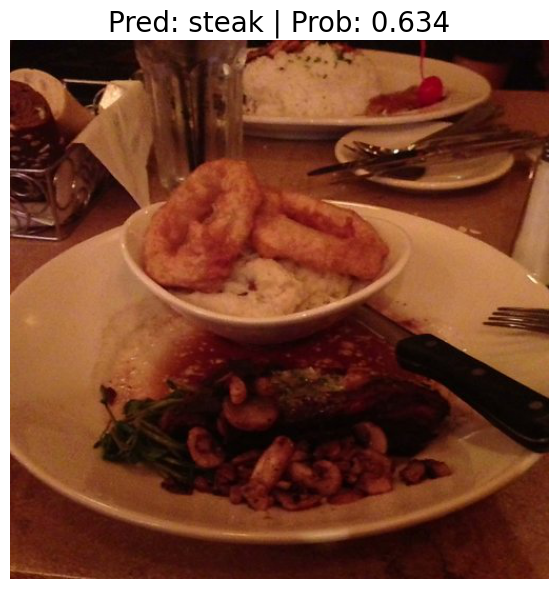

In [23]:
# Get a random subset of image paths from the test dataset
import random
from pathlib import Path

num_images = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images)

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model,
                    class_names=class_names,
                    image_path=image_path,
                    image_size=(224,224))

## 6.1 Making a prediction on a custom image

Although we've trained a model on custom data... how do you make a prediction on a sample/image that's not in either training or testing dataset.

In [24]:
# Download custom Image
import requests
from pathlib import Path

# Setup custom image path
data_path = Path("food_data")
custom_image_path = data_path/ "pizza.jpeg"

# Download the image if it does not already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # Whe downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://recipesblob.oetker.in/assets/d8a4b00c292a43adbb9f96798e028f01/1272x764/pizza-pollo-arrostojpg.jpg")
        print(f"Downloading {custom_image_path}....")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

food_data\pizza.jpeg already exists, skipping download.


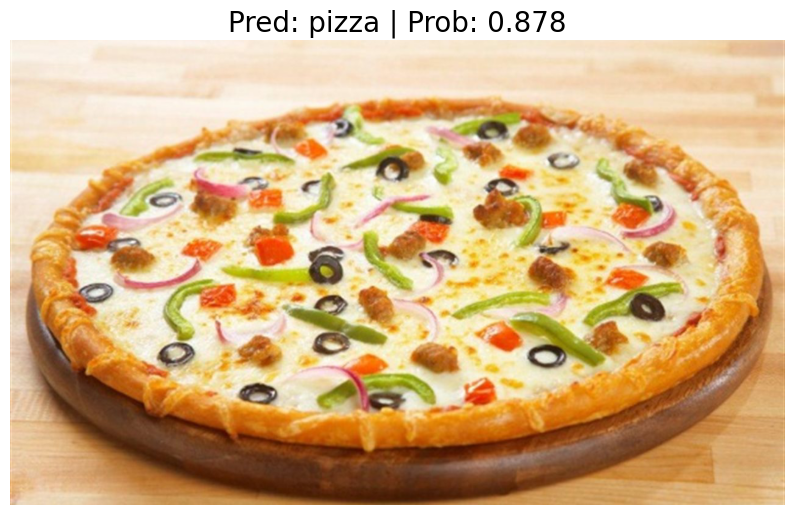

In [25]:
# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)